# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.01 # скорость обучения нейронной сети
training_steps = 4000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [3]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [4]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.weights = tf.Variable(tf.random.normal([in_features, out_features]))
        self.bias = tf.Variable(tf.zeros([out_features]))

    def __call__(self, x):
        linear = tf.matmul(x, self.weights) + self.bias
        return linear


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        # Первый слой, состоящий из 128 нейронов
        self.hidden_1 = DenseLayer(num_features, n_hidden_1, name="hidden_layer_1")

        # Второй слой, состоящий из 256 нейронов
        self.hidden_2 = DenseLayer(n_hidden_1, n_hidden_2, name="hidden_layer_2")

        # Выходной слой
        self.output_layer = DenseLayer(n_hidden_2, num_classes, name="output_layer")

    def __call__(self, x):
        x = tf.nn.sigmoid(self.hidden_1(x))
        x = tf.nn.sigmoid(self.hidden_2(x))
        x = self.output_layer(x)
        return tf.nn.softmax(x)


In [5]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Создадим экзампляр нейронной сети
neural_net = NN(name="mnist")
# optimizer = tf.optimizers.SGD(learning_rate)
optimizer = tf.optimizers.Adam(learning_rate)
# Функция обучения нейросети
@tf.function
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  # optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Создадим оптимизируемых список параметров
    trainable_variables = neural_net.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, trainable_variables)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Обновляем веса нейронной сети
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        batch_loss = cross_entropy(pred, batch_y)
        batch_accuracy = accuracy(pred, tf.cast(batch_y, tf.int64))
        loss_history.append(batch_loss)
        accuracy_history.append(batch_accuracy)

        print(f"Step {step}, Loss: {batch_loss}, Accuracy: {batch_accuracy}")

Step 0, Loss: 2602.144287109375, Accuracy: 0.18359375
Step 100, Loss: 131.49098205566406, Accuracy: 0.8515625
Step 200, Loss: 87.7212142944336, Accuracy: 0.89453125
Step 300, Loss: 89.74462127685547, Accuracy: 0.8828125
Step 400, Loss: 49.02406311035156, Accuracy: 0.94921875
Step 500, Loss: 43.67734909057617, Accuracy: 0.93359375
Step 600, Loss: 66.83012390136719, Accuracy: 0.94140625
Step 700, Loss: 29.137271881103516, Accuracy: 0.96484375
Step 800, Loss: 42.5916633605957, Accuracy: 0.9609375
Step 900, Loss: 25.154170989990234, Accuracy: 0.96875
Step 1000, Loss: 11.382943153381348, Accuracy: 0.98828125
Step 1100, Loss: 33.14203643798828, Accuracy: 0.96875
Step 1200, Loss: 17.82927703857422, Accuracy: 0.984375
Step 1300, Loss: 15.801382064819336, Accuracy: 0.9921875
Step 1400, Loss: 11.336481094360352, Accuracy: 0.984375
Step 1500, Loss: 7.754883766174316, Accuracy: 0.9921875
Step 1600, Loss: 7.789102554321289, Accuracy: 0.9921875
Step 1700, Loss: 7.558724403381348, Accuracy: 0.9882812

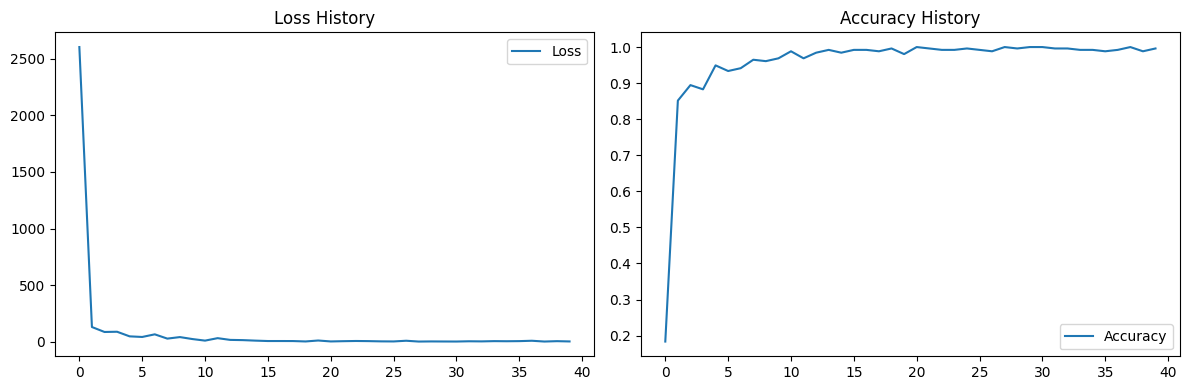

In [8]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.legend()
plt.title('Loss History')

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.legend()
plt.title('Accuracy History')

plt.tight_layout()
plt.show()

In [9]:
# Вычислите точность обученной нейросети
pred = neural_net(x_test)
print(f'Test Accuracy: {accuracy(pred, y_test)*100:.2f}%')

Test Accuracy: 96.44%


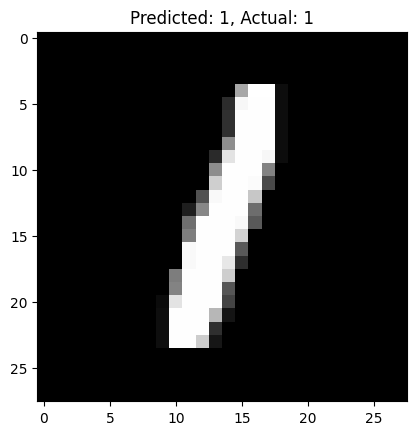

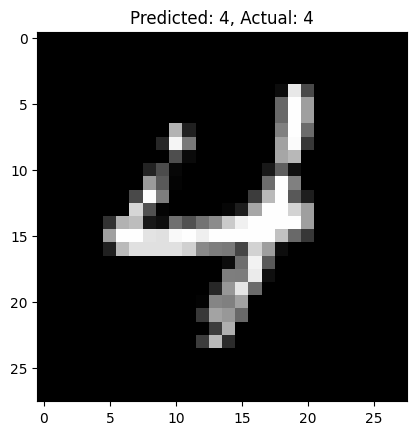

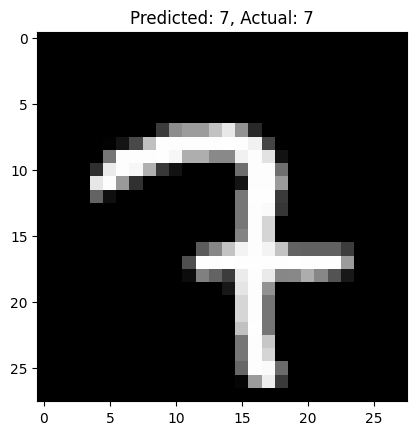

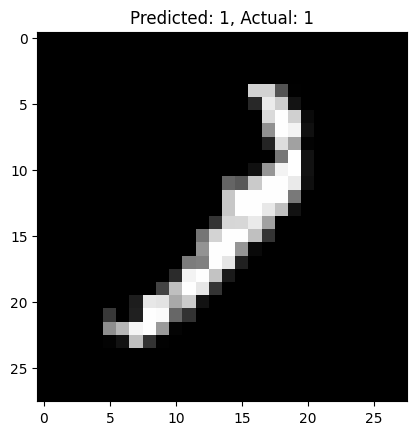

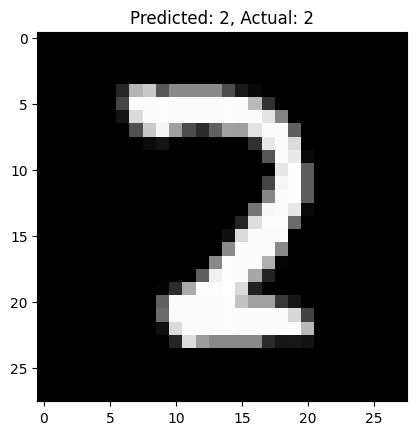

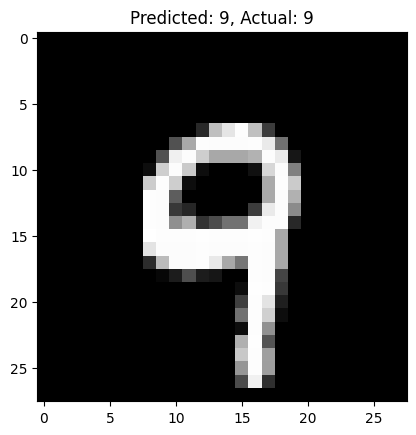

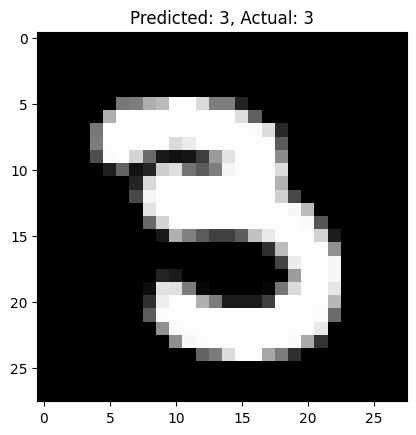

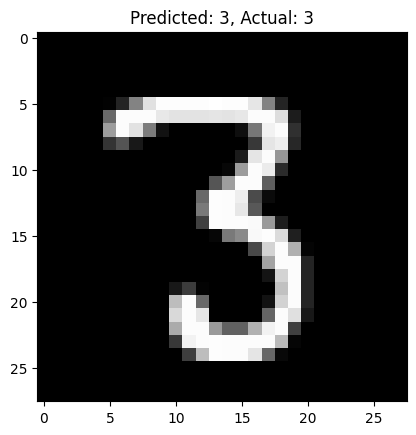

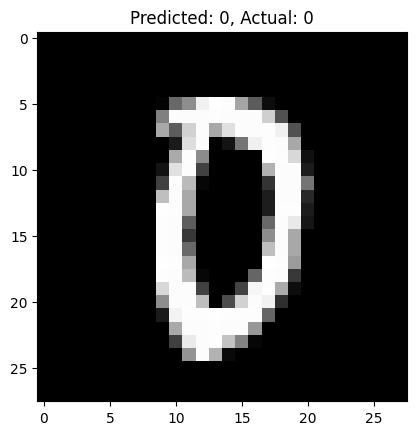

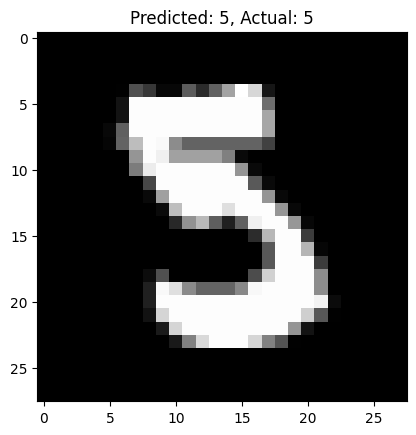

In [10]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?

error_count = 0
random_samples = np.random.choice(x_test.shape[0], 10)
for idx in random_samples:
    prediction = np.argmax(neural_net(x_test[idx].reshape(1, -1)))
    if prediction != y_test[idx]:
        error_count += 1
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f"Predicted: {prediction}, Actual: {y_test[idx]}")
    plt.show()


In [11]:
print(f"Відповідь: З {len(random_samples)} тестових зображень, нейромережа зробила {error_count} помилок.")

Відповідь: З 10 тестових зображень, нейромережа зробила 0 помилок.
